In [393]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import datetime
import os
from pprint import pprint
import matplotlib.pyplot as plt
import time
import vectorbt as vbt
from time import time
import helpers as pth
import platform
from dotenv import load_dotenv


pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)

plt.style.use("classic")
# plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.limits"] = [-1000000000, 1000000000]


if platform.system().lower() == "windows":
    base_data_path = "H:\\phitech-data\\01_raw"
else:
    from core_chains.simple.llm import make_Q_chain

    base_data_path = "../../phitech-data/01_raw"
    load_dotenv("../../sandatasci-core/credentials")
    Q = make_Q_chain("gpt-4o-instance1", __vsc_ipynb_file__)

In [396]:
I = pth.load_instruments(base_path=base_data_path)
I.keys()

dict_keys(['6B', 'MES'])

### Information Coefficient

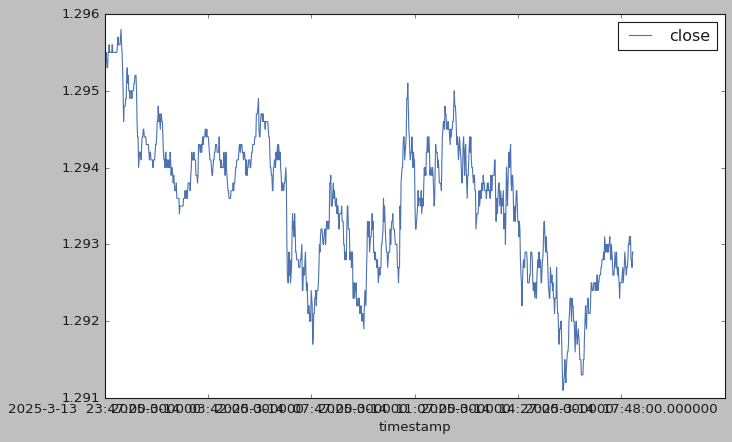

In [397]:
df = I["6B"].iloc[-1024:][["close"]]
df.plot()
plt.show()

In [398]:
periods = range(5, 65, 5)
for p in periods:
    df[f"frets_{p}"] = df.close.pct_change(-p)

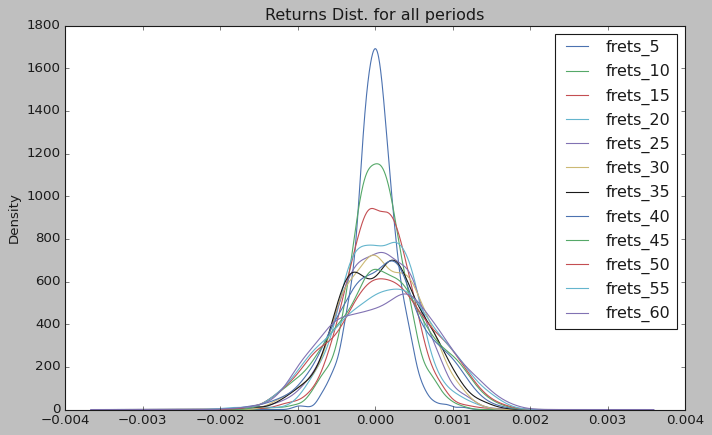

In [399]:
df.dropna(inplace=True)
for p in periods:
    df[f"frets_{p}"].plot(
        kind="kde", legend=True, title="Returns Dist. for all periods"
    )
plt.show()

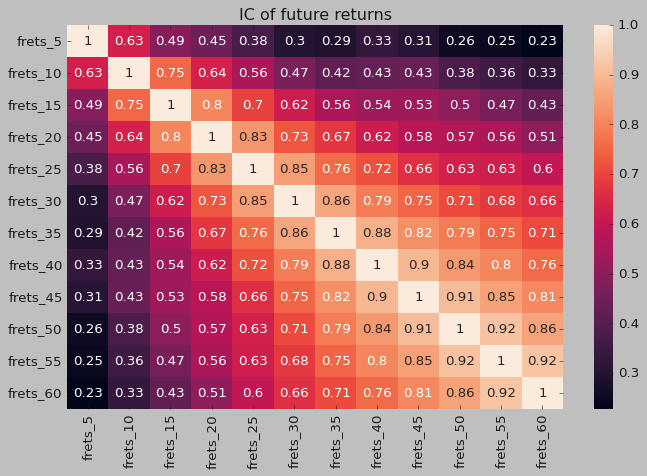

In [400]:
import seaborn as sns

cmatrix = df[[c for c in df.columns if c != "close"]].corr(method="spearman")
sns.heatmap(cmatrix, annot=True)
plt.title("IC of future returns")
plt.show()

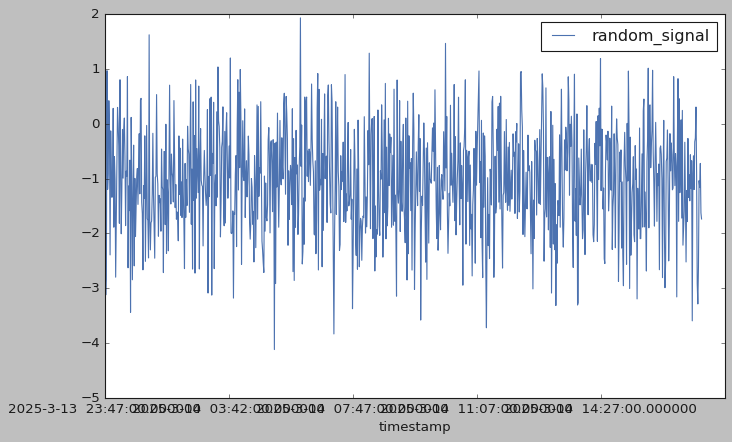

In [401]:
df["random_signal"] = np.random.normal(-1, 1, size=df.shape[0])
df.random_signal.plot(legend=True)
plt.show()

In [402]:
print("-------CORRELATION OF RANDOM_SIGNAL WITH FUTURE RETURNS-------\n")
for c in df.columns:
    if "rets" in c:
        current = stats.spearmanr(df["random_signal"], df[c])
        print(f"IC for C={c} -> {current.statistic}")

-------CORRELATION OF RANDOM_SIGNAL WITH FUTURE RETURNS-------

IC for C=frets_5 -> -0.022466259283238952
IC for C=frets_10 -> 0.02047197056192924
IC for C=frets_15 -> 0.01157555046732555
IC for C=frets_20 -> 0.012094546832793705
IC for C=frets_25 -> -0.0007937900282103299
IC for C=frets_30 -> 0.025318324694566775
IC for C=frets_35 -> 0.021733914721374297
IC for C=frets_40 -> 0.03663644773389367
IC for C=frets_45 -> 0.025556591711906045
IC for C=frets_50 -> 0.023529216845108867
IC for C=frets_55 -> 0.03779977183921396
IC for C=frets_60 -> 0.029182056426541696


### Rolling Information Coefficient

In [404]:
res = df[["frets_5", "frets_10"]]
res

,frets_5,frets_10
timestamp,,
2025-3-13 23:47:00.000000,0.000077,-0.000077
2025-3-13 23:49:00.000000,0.000077,-0.000077
2025-3-13 23:51:00.000000,-0.000077,-0.000077
2025-3-13 23:53:00.000000,0.000000,0.000000
2025-3-13 23:54:00.000000,-0.000154,-0.000077
...,...,...
2025-3-14 17:06:00.000000,-0.000155,-0.000309
2025-3-14 17:07:00.000000,-0.000155,-0.000232
2025-3-14 17:08:00.000000,-0.000155,-0.000232


count    905.000000
mean       0.619065
std        0.093968
min        0.384418
25%        0.552693
50%        0.626209
75%        0.688640
max        0.848486
Name: frets_5, dtype: float64


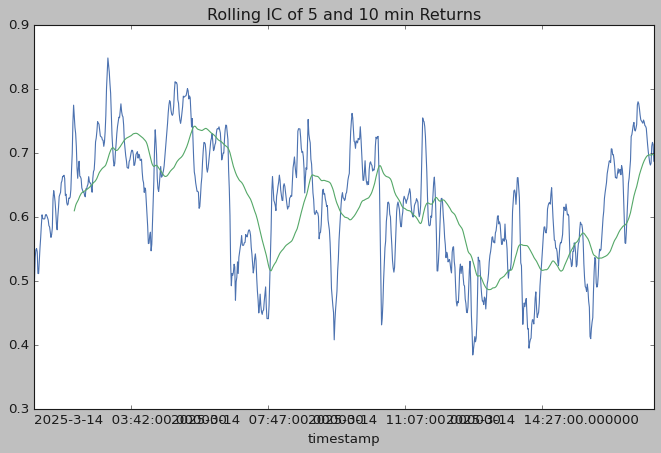

In [405]:
rolling_rets = df.frets_5.rolling(window=60).apply(
    lambda x: abs(stats.spearmanr(x, df.frets_10.loc[x.index]).statistic), raw=False
)
print(rolling_rets.describe())
rolling_rets.plot(title="Rolling IC of 5 and 10 min Returns")
rolling_rets.rolling(window=60).mean().plot()
plt.show()

In [422]:
stats.ttest_ind(
    rolling_rets.dropna(),
    np.random.normal(-1, 1, size=rolling_rets.shape[0]),
    equal_var=False,
)

TtestResult(statistic=np.float64(53.28302287064452), pvalue=np.float64(4.880855947403857e-292), df=np.float64(982.4105845362377))